In [1]:
from collections import defaultdict
import surprise
from surprise import Dataset
from surprise import Reader
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS
from surprise.model_selection.search import GridSearchCV
import seaborn as sns

In [2]:
file_path = '/Users/jameskim/Develop/Personal/S2019/IMMA/imma-term-project/Project3/data/user_game_log.dat'
df = pd.read_csv(file_path, sep='\t', names=['user', 'game', 'score'])
df

,user,game,score
0,1,The Elder Scrolls V Skyrim,2.437751
1,1,Fallout 4,1.944483
2,1,Spore,1.201397
3,1,Fallout New Vegas,1.117271
4,1,Left 4 Dead 2,0.995635
5,1,HuniePop,0.977724
6,1,Path of Exile,0.959041
7,1,Poly Bridge,0.929419
8,1,Left 4 Dead,0.633468
9,1,Team Fortress 2,0.579784


In [3]:
df_stat = df.groupby(by='user')['score'].describe(percentiles=[])
df_stat['std'].fillna(0, inplace=True)
df_stat

,count,mean,std,min,50%,max
user,,,,,,
1,26.0,0.604802,0.588382,0.041393,0.370970,2.437751
2,1.0,0.518514,0.000000,0.518514,0.518514,0.518514
3,22.0,0.769913,0.639866,0.041393,0.633351,2.378398
4,197.0,0.567391,0.484226,0.041393,0.397940,1.939519
5,1.0,1.146128,0.000000,1.146128,1.146128,1.146128
6,7.0,1.127375,0.583539,0.322219,1.053078,1.968483
7,1.0,1.004321,0.000000,1.004321,1.004321,1.004321
8,1.0,0.176091,0.000000,0.176091,0.176091,0.176091
9,1.0,1.633468,0.000000,1.633468,1.633468,1.633468


In [4]:
clustering = MiniBatchKMeans(n_clusters=8, random_state=0)
clustering.fit(df_stat)
label_arr = clustering.labels_

# 각 cluster 별로 개수를 확인
pd.DataFrame(label_arr, columns=['label']) \
    .groupby('label')['label'].describe()[['count']]

,count
label,
0,2644.0
1,259.0
2,43.0
3,721.0
4,5742.0
5,150.0
6,1357.0
7,434.0


In [5]:
pd.DataFrame(clustering.cluster_centers_,
             columns=['count', 'mean', 'std', 'min', '50%', 'max'])

,count,mean,std,min,50%,max
0,1.305948,1.919776,0.208003,1.762296,1.918749,2.078332
1,43.682569,0.874313,0.610735,0.064024,0.780842,2.543762
2,179.416667,0.747480,0.532588,0.045386,0.652748,2.667739
3,12.305038,0.912262,0.655160,0.141238,0.789983,2.185760
4,1.272829,0.532435,0.090456,0.464402,0.526416,0.606488
5,83.363897,0.870391,0.599210,0.052342,0.784171,2.644424
6,5.319588,0.982463,0.700680,0.273290,0.862277,1.947438
7,23.271523,0.909542,0.641935,0.091662,0.802999,2.419897


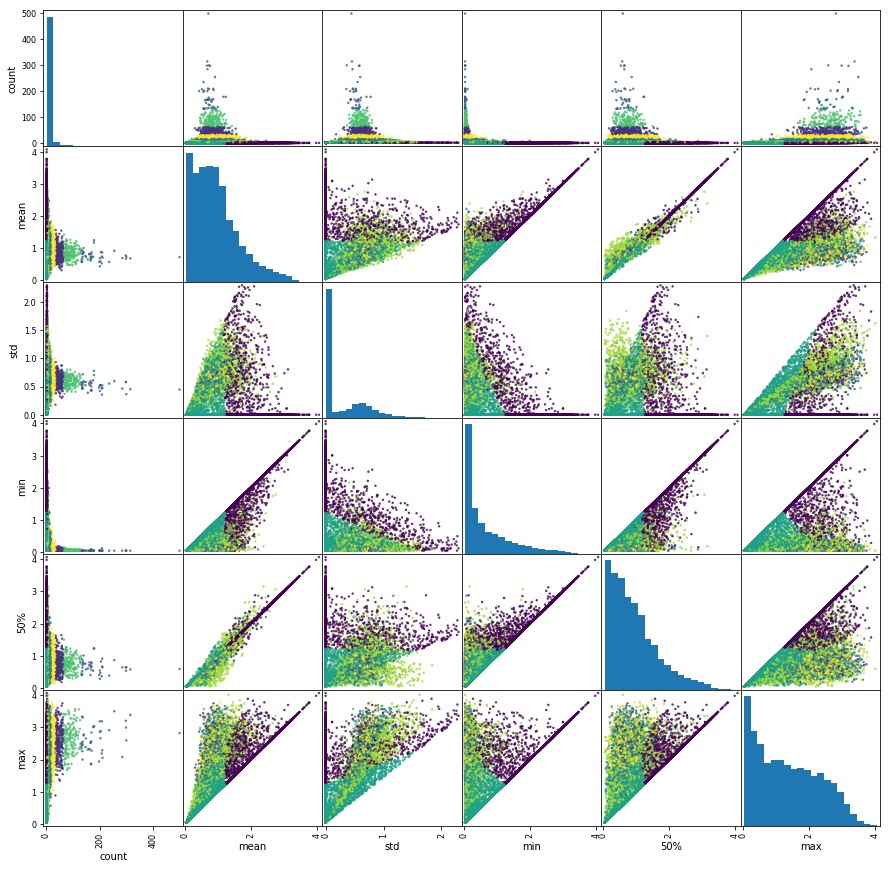

In [6]:
grr = pd.plotting.scatter_matrix(df_stat, c=label_arr, figsize=(15, 15), marker='o',
                                 hist_kwds={'bins': 20}, s=6, alpha=.8)

In [7]:
algo_list = [
    {
        'name': 'BaselineOnly (ALS)',
        'algo': surprise.BaselineOnly,
        'param_grid': {
            'bsl_options' : {
                'method':['als'],
                'n_epochs' : [5, 10],
                'reg_i' : [3, 5, 7],
                'reg_u' : [13, 15, 17]
            }
        }
    },
    {
        'name': 'BaselineOnly (SDG)',
        'algo': surprise.BaselineOnly,
        'param_grid': {
            'bsl_options' : {
                'method':['sgd'],
                'n_epochs' : [10, 20, 30],
                'reg' : [0.005, 0.01, 0.015],
            }
        }
    },
    {
        'name': 'SVD (No Bias)',
        'algo': surprise.SVD,
        'param_grid': {
            'n_factors': [4, 5, 6, 7, 8],
            'reg_all': [0.05, 0.06, 0.07, 0.08],
            'biased': [False],
            'n_epochs': [100]
        }
    },
    {
        'name': 'SVD (Biased)',
        'algo': surprise.SVD,
        'param_grid': {
            'n_factors': [10, 12, 14],
            'reg_all': [0.0004, 0.0005, 0.0006],
            'biased': [True],
            'n_epochs': [20, 35, 50]
        }
    },
    {
        'name': 'SVD++',
        'algo': surprise.SVDpp,
        'param_grid': {
            'n_factors': [10, 12, 14],
            'reg_all': [0.001, 0.0015, 0.002],
            'n_epochs': [20]
        }
    },
    {
        'name': 'KNNBasic',
        'algo': surprise.KNNBasic,
        'param_grid': {
            'k': [80, 90, 100],
            'min_k': [1, 2, 3, 4],
            'sim_options': {
                'name': ['msd'],
                'user_based': [True]
            }
        }
    },
    {
        'name': 'KNNWithMeans',
        'algo': surprise.KNNWithMeans,
        'param_grid': {
            'k': [40, 50, 60],
            'min_k': [5, 7, 9],
            'sim_options': {
                'name': ['cosine'],
                'user_based': [False]
            }
        }
    },
    {
        'name': 'KNNWithZScore',
        'algo': surprise.KNNWithZScore,
        'param_grid': {
            'k': [30, 40, 50],
            'min_k': [10, 15, 20],
            'sim_options': {
                'name': ['cosine'],
                'user_based': [False]
            }
        }
    },
    {
        'name': 'KNNBaseline',
        'algo': surprise.KNNBaseline,
        'param_grid': {
            'k': [50, 60, 70],
            'min_k': [10, 20, 30],
            'sim_options': {
                'name': ['pearson_baseline'],
                'user_based': [False]
            },
            'bsl_options': {
                'method': ['sgd'],
                'n_epochs': [20],
            }
        }
    }
]

In [8]:
cluster_map = {}
for i in range(len(df_stat)):
    user = df_stat.index[i]
    cluster_map[user] = label_arr[i]

In [9]:
df_clusters = df.groupby(lambda x: cluster_map[df.loc[x].user])
df_clusters = dict(list(df_clusters))

In [10]:
def fit_algorithm(algo_info, data):
    algo = algo_info['algo']
    param_grid = algo_info['param_grid']
    
    gs = GridSearchCV(algo, param_grid, measures=['rmse'],
                      cv=3, n_jobs=16, joblib_verbose=0)
    gs.fit(data)
    return gs
    
# Best algorithms for each cluster_df
gs_dict = {}
reader = Reader(line_format='user item rating', sep='\t')
for (cluster_label, cluster_df) in df_clusters.items():
    data = Dataset.load_from_df(cluster_df, reader=reader)
    print(f'Cluster: {cluster_label}')
    for algo_info in algo_list:
        algo_name = algo_info['name']
        print('\tFitting: ' + algo_name)
        gs = fit_algorithm(algo_info, data)
        best_score = gs.best_score['rmse']
        best_params = gs.best_params['rmse']
        print('\tResult: ' + str(best_score))
        print('\tParam: ' + str(best_params))
        
        if cluster_label not in gs_dict:
            gs_dict[cluster_label] = (gs, algo_info)
        else:
            old_best_gs = gs_dict[cluster_label][0]
            old_best_score = old_best_gs.best_score['rmse']
            if best_score < old_best_score: # 작을수록 좋은 것이다.
                gs_dict[cluster_label] = (gs, algo_info)

    (gs, algo_info) = gs_dict[cluster_label]
    print('\tOverall Best')
    print('\tAlgo: ' + str(algo_info['name']))
    print('\tResult: ' + str(gs.best_score['rmse']))
    print('\tParam: ' + str(gs.best_params['rmse']))

Cluster: 0
	Fitting: BaselineOnly (ALS)
	Result: 0.6610691489306775
	Param: {'bsl_options': {'method': 'als', 'n_epochs': 5, 'reg_i': 3, 'reg_u': 17}}
	Fitting: BaselineOnly (SDG)
	Result: 0.6703585900724196
	Param: {'bsl_options': {'method': 'sgd', 'n_epochs': 10, 'reg': 0.005}}
	Fitting: SVD (No Bias)
	Result: 0.7900153302493136
	Param: {'n_factors': 5, 'reg_all': 0.05, 'biased': False, 'n_epochs': 100}
	Fitting: SVD (Biased)
	Result: 0.6685233416241662
	Param: {'n_factors': 14, 'reg_all': 0.0006, 'biased': True, 'n_epochs': 20}
	Fitting: SVD++
	Result: 0.6823143442205978
	Param: {'n_factors': 14, 'reg_all': 0.002, 'n_epochs': 20}
	Fitting: KNNBasic
	Result: 0.6867805554345376
	Param: {'k': 80, 'min_k': 1, 'sim_options': {'name': 'msd', 'user_based': True}}
	Fitting: KNNWithMeans
	Result: 0.6821777387624656
	Param: {'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': False}}
	Fitting: KNNWithZScore
	Result: 0.6806287691213647
	Param: {'k': 30, 'min_k': 10, 'sim_optio

	Result: 0.7380705225636072
	Param: {'bsl_options': {'method': 'als', 'n_epochs': 5, 'reg_i': 3, 'reg_u': 15}}
	Fitting: BaselineOnly (SDG)
	Result: 0.7385532177653212
	Param: {'bsl_options': {'method': 'sgd', 'n_epochs': 20, 'reg': 0.005}}
	Fitting: SVD (No Bias)
	Result: 0.7782878243347477
	Param: {'n_factors': 4, 'reg_all': 0.08, 'biased': False, 'n_epochs': 100}
	Fitting: SVD (Biased)
	Result: 0.7405553472679514
	Param: {'n_factors': 14, 'reg_all': 0.0006, 'biased': True, 'n_epochs': 20}
	Fitting: SVD++
	Result: 0.7441068700232677
	Param: {'n_factors': 10, 'reg_all': 0.001, 'n_epochs': 20}
	Fitting: KNNBasic
	Result: 0.7533964870520508
	Param: {'k': 100, 'min_k': 2, 'sim_options': {'name': 'msd', 'user_based': True}}
	Fitting: KNNWithMeans
	Result: 0.7479024744451793
	Param: {'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': False}}
	Fitting: KNNWithZScore
	Result: 0.7525420493981976
	Param: {'k': 30, 'min_k': 10, 'sim_options': {'name': 'cosine', 'user_based': F